# Lab3b Magnetometer Data Analysis: Part 2
Contents of this notebook are developed by Dogacan Su Ozturk for the GEOS 419 Lecture. 

# This notebook

1. Loading EZIE Magnetometer Data from the Class Deployment
   - Reading the data
   - Removing erroneous data
   - Removing outliers
   - Searching for other artificial signatures
2. Downloading GIMA and USGS Magnetometer Data
   - Downloading data for Poker Flat (GIMA) and College (USGS) sites
3. Comparing EZIE measurements with the science grade magnetometers
   - Plotting data with Matplotlib
   - Analyzing the warm-up period
   - Removing baseline
   - Labelling and saving figures
4. Investigating the spatial extent of the geomagnetic perturbations
   - Comparison along a similar longitude
   - Comparison along similar latitudes


### 1. Loading EZIE Magnetometer Data from the Class Deployment
We have completed the first part of this laboratory class and we are now able to read and clean EZIE magnetometer data. Let's import the libraries we have used before and analyze the data from the deployment.

In [1]:
# Essential Python libraries for this exercise
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%D/%m %H:%M')
%matplotlib widget 

# Libraries for unzipping eziemag data
from ezie_mag_helper_functions import unzip_ezie_files

# Libraries for merging eziemag data
from ezie_mag_helper_functions import merge_eziemag_data

We can now load the data from EZIE magnetometer kits. Remember these files are now in a different path. Similar to the first part of this laboratory, we will start with the unzip_ezie_files function. Once you download the data using the eziemag.local interface, you will notice the files are zipped in a specific format. The functions you will use are geared towards 60 second averaged files. You will need to develop your own helper functions or modify the existing functionality by changing the folderpath if you wish to use 1 second data. In the examples below, we are using the unzip_ezie_files function. This function takes three parameters, the first one being the keyword string assigned to the magnetometer, the second is a string of folderpath, and the third is a logical flag if you want to copy all individual daily measurements unzipped into one big folder. By design, this folder will be placed in the folderpath, with a name appending the keyword with '_merged'.

In [2]:
geos1_filepath = unzip_ezie_files('geos1','/Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/', merge=True)
geos2_filepath = unzip_ezie_files('geos2','/Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_2/Deployment_01_20250205_17/', merge=True)
geos3_filepath = unzip_ezie_files('geos3','/Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_3/Deployment_01_20250205_17/', merge=True)

Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250210 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250214 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250211 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250205 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250215 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deployment_01_20250205_17/geos1_20250206 .
File unzipped in filepath.
Writing zip file as  /Users/dsozturk/Desktop/dozturk_uaf/Database/EZIE/GEOS_419_1/Deploy

The code cell when executed will return print statements to help users locate filepath errors. Now that a new folder for unzipped files are generated, we can start reading the data. We will use the merge_eziemag_data function to read all the measurement data obtained. This function only needs the folderpath, which the unzip_eziemag_data provides. This function, calls another function named read_and_parse_ezie_mag_data. If user wants to read and parse single day data, they can pass the folderpath for this folder instead. 

We can now pass the path to function to generate a Pandas Dataframe for measurements from each different EZIE MAG kit. 

In [3]:
geos1_data = merge_eziemag_data(geos1_filepath)
geos2_data = merge_eziemag_data(geos2_filepath)
geos3_data = merge_eziemag_data(geos3_filepath)

There are  272  files in the folder.
There are  273  files in the folder.
There are  270  files in the folder.


You probably noticed that the number of files in folders are uneven. What does that mean? Our data might be corrupted or simply the few minute difference we plugged the kits caused different amount of files. Let's use some of the pandas techniques to find out.

First, let's look at the few first rows of each DataFrame to see if the data is read correctly.

In [4]:
geos1_data.head()

,index,timeString,tval,intt,nsamp,stid,fingerprint,latitude,longitude,altitude,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
0,0,2025-02-05 01:13:57.508615+00:00,1.738718e+09,60.0,2200,eziemag_uaf_geos1,AAAAAP6rVDcA,64.858925,-147.849338,243.7,...,-37912.878009,0,0,-0.126820,0.233898,10.012766,0.005498,-0.006872,0.011148,22.214844
1,1,2025-02-05 01:14:57.530788200+00:00,1.738718e+09,60.0,2174,eziemag_uaf_geos1,AAAAAP6rVDcA,64.858925,-147.849338,243.7,...,-37841.803884,0,0,-0.130409,0.237488,9.979865,0.005803,-0.007789,0.011454,22.292969
2,2,2025-02-05 01:15:57.538987600+00:00,1.738718e+09,60.0,2202,eziemag_uaf_geos1,AAAAAP6rVDcA,64.858925,-147.849338,243.7,...,-37837.865860,0,0,-0.132203,0.241675,10.001998,0.005192,-0.007941,0.012065,22.445312
3,3,2025-02-05 01:16:57.548650700+00:00,1.738718e+09,60.0,2194,eziemag_uaf_geos1,AAAAAP6rVDcA,64.858925,-147.849338,243.7,...,-37848.093600,0,0,-0.132203,0.238086,10.022337,0.004429,-0.006872,0.011606,22.531250
4,4,2025-02-05 01:17:57.574395200+00:00,1.738718e+09,60.0,2182,eziemag_uaf_geos1,AAAAAP6rVDcA,64.858925,-147.849338,243.7,...,-37859.158661,0,0,-0.126221,0.236291,10.056435,0.005803,-0.007941,0.011606,22.597656


In [5]:
geos2_data.head()

,index,timeString,tval,intt,nsamp,stid,fingerprint,latitude,longitude,altitude,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
0,0,2025-02-05 01:14:08.857167+00:00,1.738718e+09,60.0,1961.0,eziemag_uaf_geos2,AAAAAMpVwP0A,64.860583,-147.849993,207.2,...,-40496.898363,0.0,0.0,0.145962,0.075972,9.808180,0.000000,0.002749,-0.001222,21.734375
1,1,2025-02-05 01:14:15.594654600+00:00,1.738718e+09,60.0,1979.0,eziemag_uaf_geos2,AAAAAMpVwP0A,64.860583,-147.849993,207.2,...,-40483.959143,0.0,0.0,0.109472,0.080758,9.821939,0.000305,0.002596,-0.000764,21.808594
2,2,2025-02-05 01:15:08.868001700+00:00,1.738718e+09,60.0,1958.0,eziemag_uaf_geos2,AAAAAMpVwP0A,64.860583,-147.849993,207.2,...,-40427.453088,0.0,0.0,0.132802,0.087936,9.867402,0.000611,0.002443,-0.000305,21.914062
3,3,2025-02-05 01:15:15.620936600+00:00,1.738718e+09,60.0,1983.0,eziemag_uaf_geos2,AAAAAMpVwP0A,64.860583,-147.849993,207.2,...,-40432.238244,0.0,0.0,0.128614,0.084945,9.822537,0.000611,0.003054,-0.000916,21.894531
4,4,2025-02-05 01:16:08.884662400+00:00,1.738718e+09,60.0,1955.0,eziemag_uaf_geos2,AAAAAMpVwP0A,64.860583,-147.849993,207.2,...,-40423.685145,0.0,0.0,0.133998,0.078963,9.847063,0.000153,0.002902,-0.000764,21.925781


In [6]:
geos3_data.head()

,index,timeString,tval,intt,nsamp,stid,fingerprint,latitude,longitude,altitude,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
0,0,2025-02-05 18:21:19.760954100+00:00,1.738780e+09,60.0,2030,eziemag_uaf_geos3,AAAAANZG1MUA,64.860503,-147.852093,188.3,...,-7685.597923,0,0,-0.051446,0.052044,9.883554,0.010843,-0.002596,-0.009774,22.218750
1,1,2025-02-05 18:22:19.773269200+00:00,1.738780e+09,60.0,2014,eziemag_uaf_geos3,AAAAANZG1MUA,64.860503,-147.852093,188.3,...,-7680.280446,0,0,-0.035294,0.053240,9.906286,0.010690,-0.002291,-0.009621,22.351562
2,2,2025-02-05 18:23:19.775395400+00:00,1.738780e+09,60.0,2017,eziemag_uaf_geos3,AAAAANZG1MUA,64.860503,-147.852093,188.3,...,-7677.119234,0,0,-0.028714,0.055633,9.850054,0.010232,-0.002443,-0.010232,22.437500
3,3,2025-02-05 18:24:19.796155+00:00,1.738780e+09,60.0,2031,eziemag_uaf_geos3,AAAAANZG1MUA,64.860503,-147.852093,188.3,...,-7676.290908,0,0,-0.043669,0.054437,9.906884,0.010996,-0.002291,-0.009774,22.609375
4,4,2025-02-05 18:25:19.811198500+00:00,1.738780e+09,60.0,2032,eziemag_uaf_geos3,AAAAANZG1MUA,64.860503,-147.852093,188.3,...,-5612.170994,0,0,-0.031107,-0.010768,9.851251,0.010690,-0.002596,-0.009774,22.699219


Now, let's analyze each DataFrame to see if there is even numbers of data in all columns using .describe() functionality. 

In [7]:
geos1_data.describe()

,index,tval,intt,nsamp,latitude,longitude,altitude,tres,ctemp,ccr,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
count,16221.000000,1.622100e+04,16221.0,16221.000000,16221.000000,16221.000000,16221.000000,16221.0,16221.000000,16221.0,...,16221.000000,16221.0,16221.0,16221.000000,16221.000000,16221.000000,16221.000000,16221.000000,16221.000000,16221.000000
mean,29.422539,1.739263e+09,60.0,2119.462857,64.860456,-147.852148,187.665138,3.0,-2.454935,800.0,...,-50560.536395,0.0,0.0,0.071904,0.335416,10.073544,0.001053,-0.005950,0.008328,-3.257057
std,17.314915,2.814456e+05,0.0,11.253685,0.000107,0.000193,6.770682,0.0,3.168224,0.0,...,1509.724195,0.0,0.0,0.105711,0.164936,0.164237,0.007696,0.014766,0.017399,3.401025
min,0.000000,1.738718e+09,60.0,2058.000000,64.858925,-147.852378,165.000000,3.0,-6.375000,800.0,...,-51852.800258,0.0,0.0,-2.892324,-9.681958,-1.485943,-0.055283,-1.410488,-2.040901,-7.593750
25%,14.000000,1.739020e+09,60.0,2112.000000,64.860438,-147.852188,184.000000,3.0,-4.312500,800.0,...,-50705.357076,0.0,0.0,0.068195,0.333201,10.072587,0.000458,-0.006261,0.008094,-5.335938
50%,29.000000,1.739264e+09,60.0,2117.000000,64.860463,-147.852160,188.400000,3.0,-3.437500,800.0,...,-50646.254018,0.0,0.0,0.072981,0.339183,10.076774,0.000916,-0.005956,0.008399,-4.253906
75%,44.000000,1.739507e+09,60.0,2125.000000,64.860487,-147.852130,191.800000,3.0,-0.937500,800.0,...,-50594.258373,0.0,0.0,0.078365,0.344566,10.080962,0.001374,-0.005651,0.008705,-1.453125
max,59.000000,1.739750e+09,60.0,2254.000000,64.860618,-147.849338,243.700000,3.0,26.750000,800.0,...,19863.598983,0.0,0.0,12.385848,0.391226,10.111470,0.807106,1.112233,0.754266,26.917969


In [8]:
geos2_data.describe()

,index,tval,intt,nsamp,latitude,longitude,altitude,tres,ctemp,ccr,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
count,16332.000000,1.633000e+04,16330.0,16330.000000,16330.000000,16330.000000,16330.000000,16330.0,16330.000000,16330.0,...,16330.000000,16330.0,16330.0,16330.000000,16330.000000,16330.000000,16330.000000,16330.000000,16330.000000,16330.000000
mean,29.501408,1.739260e+09,60.0,1935.596387,64.860431,-147.852093,188.172437,3.0,-3.816989,800.0,...,-52431.497998,0.0,0.0,0.257271,-0.287136,9.805396,-0.001829,0.003555,0.002596,-4.708654
std,17.412540,2.836731e+05,0.0,16.619725,0.000031,0.000226,4.594432,0.0,4.225216,0.0,...,1180.819694,0.0,0.0,0.033075,0.087374,0.091740,0.003816,0.003547,0.008094,4.339423
min,0.000000,1.738718e+09,60.0,1852.000000,64.860335,-147.852273,171.800000,3.0,-8.437500,800.0,...,-67153.162380,0.0,0.0,-2.437090,-9.570094,-1.788037,-0.421192,-0.431424,-0.315970,-9.519531
25%,14.000000,1.739015e+09,60.0,1925.000000,64.860412,-147.852145,185.100000,3.0,-6.125000,800.0,...,-52552.995687,0.0,0.0,0.254836,-0.293719,9.801600,-0.002138,0.003360,0.002291,-7.144531
50%,29.000000,1.739260e+09,60.0,1931.000000,64.860430,-147.852117,188.200000,3.0,-5.187500,800.0,...,-52502.130916,0.0,0.0,0.259023,-0.290130,9.805787,-0.001833,0.003665,0.002596,-6.121094
75%,44.000000,1.739505e+09,60.0,1945.000000,64.860448,-147.852083,191.200000,3.0,-2.250000,800.0,...,-52463.034423,0.0,0.0,0.263210,-0.285942,9.809376,-0.001527,0.003818,0.002902,-3.011719
max,91.000000,1.739750e+09,60.0,2141.000000,64.860583,-147.849993,207.200000,3.0,26.875000,800.0,...,-23459.143475,0.0,0.0,1.975873,2.202593,9.953544,0.141721,0.060018,0.976926,26.566406


In [9]:
geos3_data.describe()

,index,tval,intt,nsamp,latitude,longitude,altitude,tres,ctemp,ccr,...,Bz,afs_sel,fs_sel,Ax,Ay,Az,Gx,Gy,Gz,imu_ctemp
count,16158.000000,1.615800e+04,16158.0,16158.000000,16158.000000,16158.000000,16158.000000,16158.0,16158.000000,16158.0,...,16158.000000,16158.0,16158.0,16158.000000,16158.000000,16158.000000,16158.000000,16158.000000,16158.000000,16158.000000
mean,29.460329,1.739266e+09,60.0,1931.341441,64.860431,-147.852067,189.502934,3.0,-1.288027,800.0,...,-50949.857859,0.0,0.0,-0.464472,-0.070511,9.891220,0.008085,0.000563,-0.010304,-2.020660
std,17.314372,2.799487e+05,0.0,10.657523,0.000023,0.000052,5.792560,0.0,2.301195,0.0,...,1257.138208,0.0,0.0,0.023541,0.093281,0.066343,0.005557,0.008599,0.007555,2.371220
min,0.000000,1.738780e+09,60.0,1846.000000,64.860328,-147.852235,176.600000,3.0,-4.750000,800.0,...,-51394.664885,0.0,0.0,-0.971486,-11.484950,1.503889,-0.670577,-1.027475,-0.807106,-5.664062
25%,14.000000,1.739023e+09,60.0,1925.000000,64.860418,-147.852097,188.800000,3.0,-2.562500,800.0,...,-51027.701784,0.0,0.0,-0.471984,-0.074776,9.887741,0.007636,0.000153,-0.010537,-3.390625
50%,29.000000,1.739266e+09,60.0,1929.000000,64.860430,-147.852063,189.100000,3.0,-2.062500,800.0,...,-50987.534110,0.0,0.0,-0.466600,-0.069392,9.891929,0.008094,0.000764,-0.010232,-2.781250
75%,44.000000,1.739508e+09,60.0,1936.000000,64.860443,-147.852050,189.900000,3.0,-0.125000,800.0,...,-50951.327354,0.0,0.0,-0.459422,-0.064008,9.896116,0.008552,0.001069,-0.009927,-0.770508
max,59.000000,1.739750e+09,60.0,2473.000000,64.860550,-147.851913,210.200000,3.0,23.125000,800.0,...,7551.720666,0.0,0.0,1.502693,0.742971,10.095917,0.011301,0.038790,-0.008399,22.835938


Is there anything going on? Now let's check if there is any corrupted data by looking for NaNs or NaTs in the DataFrame.

In [10]:
for key in geos1_data.keys():
    print('Key: ', key, 'Amount of NaNs: ', geos1_data[key].isnull().sum())

Key:  index Amount of NaNs:  0
Key:  timeString Amount of NaNs:  0
Key:  tval Amount of NaNs:  0
Key:  intt Amount of NaNs:  0
Key:  nsamp Amount of NaNs:  0
Key:  stid Amount of NaNs:  0
Key:  fingerprint Amount of NaNs:  0
Key:  latitude Amount of NaNs:  0
Key:  longitude Amount of NaNs:  0
Key:  altitude Amount of NaNs:  0
Key:  tres Amount of NaNs:  0
Key:  ctemp Amount of NaNs:  0
Key:  ccr Amount of NaNs:  0
Key:  Bx Amount of NaNs:  0
Key:  By Amount of NaNs:  0
Key:  Bz Amount of NaNs:  0
Key:  afs_sel Amount of NaNs:  0
Key:  fs_sel Amount of NaNs:  0
Key:  Ax Amount of NaNs:  0
Key:  Ay Amount of NaNs:  0
Key:  Az Amount of NaNs:  0
Key:  Gx Amount of NaNs:  0
Key:  Gy Amount of NaNs:  0
Key:  Gz Amount of NaNs:  0
Key:  imu_ctemp Amount of NaNs:  0


In [11]:
for key in geos2_data.keys():
    print('Key: ', key, 'Amount of NaNs: ', geos2_data[key].isnull().sum())

Key:  index Amount of NaNs:  0
Key:  timeString Amount of NaNs:  2
Key:  tval Amount of NaNs:  2
Key:  intt Amount of NaNs:  2
Key:  nsamp Amount of NaNs:  2
Key:  stid Amount of NaNs:  2
Key:  fingerprint Amount of NaNs:  2
Key:  latitude Amount of NaNs:  2
Key:  longitude Amount of NaNs:  2
Key:  altitude Amount of NaNs:  2
Key:  tres Amount of NaNs:  2
Key:  ctemp Amount of NaNs:  2
Key:  ccr Amount of NaNs:  2
Key:  Bx Amount of NaNs:  2
Key:  By Amount of NaNs:  2
Key:  Bz Amount of NaNs:  2
Key:  afs_sel Amount of NaNs:  2
Key:  fs_sel Amount of NaNs:  2
Key:  Ax Amount of NaNs:  2
Key:  Ay Amount of NaNs:  2
Key:  Az Amount of NaNs:  2
Key:  Gx Amount of NaNs:  2
Key:  Gy Amount of NaNs:  2
Key:  Gz Amount of NaNs:  2
Key:  imu_ctemp Amount of NaNs:  2


In [12]:
for key in geos3_data.keys():
    print('Key: ', key, 'Amount of NaNs: ', geos3_data[key].isnull().sum())

Key:  index Amount of NaNs:  0
Key:  timeString Amount of NaNs:  2
Key:  tval Amount of NaNs:  0
Key:  intt Amount of NaNs:  0
Key:  nsamp Amount of NaNs:  0
Key:  stid Amount of NaNs:  0
Key:  fingerprint Amount of NaNs:  0
Key:  latitude Amount of NaNs:  0
Key:  longitude Amount of NaNs:  0
Key:  altitude Amount of NaNs:  0
Key:  tres Amount of NaNs:  0
Key:  ctemp Amount of NaNs:  0
Key:  ccr Amount of NaNs:  0
Key:  Bx Amount of NaNs:  0
Key:  By Amount of NaNs:  0
Key:  Bz Amount of NaNs:  0
Key:  afs_sel Amount of NaNs:  0
Key:  fs_sel Amount of NaNs:  0
Key:  Ax Amount of NaNs:  0
Key:  Ay Amount of NaNs:  0
Key:  Az Amount of NaNs:  0
Key:  Gx Amount of NaNs:  0
Key:  Gy Amount of NaNs:  0
Key:  Gz Amount of NaNs:  0
Key:  imu_ctemp Amount of NaNs:  0


We have some corrupted data in geos2 and geos3. Let's remove these data points. 

In [13]:
geos2_data.dropna(inplace=True)
geos3_data.dropna(inplace=True)

In [14]:
for key in geos2_data.keys():
    print('Key: ', key, 'Amount of NaNs: ', geos2_data[key].isnull().sum())

Key:  index Amount of NaNs:  0
Key:  timeString Amount of NaNs:  0
Key:  tval Amount of NaNs:  0
Key:  intt Amount of NaNs:  0
Key:  nsamp Amount of NaNs:  0
Key:  stid Amount of NaNs:  0
Key:  fingerprint Amount of NaNs:  0
Key:  latitude Amount of NaNs:  0
Key:  longitude Amount of NaNs:  0
Key:  altitude Amount of NaNs:  0
Key:  tres Amount of NaNs:  0
Key:  ctemp Amount of NaNs:  0
Key:  ccr Amount of NaNs:  0
Key:  Bx Amount of NaNs:  0
Key:  By Amount of NaNs:  0
Key:  Bz Amount of NaNs:  0
Key:  afs_sel Amount of NaNs:  0
Key:  fs_sel Amount of NaNs:  0
Key:  Ax Amount of NaNs:  0
Key:  Ay Amount of NaNs:  0
Key:  Az Amount of NaNs:  0
Key:  Gx Amount of NaNs:  0
Key:  Gy Amount of NaNs:  0
Key:  Gz Amount of NaNs:  0
Key:  imu_ctemp Amount of NaNs:  0


Now let's see if we have any outliers. How can we do that?

In [15]:
for key in geos2_data.keys():
    print('Key: ', key, 'Min: ', geos2_data[key].min(), 'Max: ', geos2_data[key].max())

Key:  index Min:  0 Max:  91
Key:  timeString Min:  2025-02-05 01:14:08.857167+00:00 Max:  2025-02-16 23:59:33.145725700+00:00
Key:  tval Min:  1738718048.857167 Max:  1739750373.145726
Key:  intt Min:  60.0 Max:  60.0
Key:  nsamp Min:  1852.0 Max:  2141.0
Key:  stid Min:  eziemag_uaf_geos2 Max:  eziemag_uaf_geos2
Key:  fingerprint Min:  AAAAAMpVwP0A Max:  AAAAAMpVwP0A
Key:  latitude Min:  64.860335 Max:  64.860583
Key:  longitude Min:  -147.852273 Max:  -147.849993
Key:  altitude Min:  171.8 Max:  207.2
Key:  tres Min:  3.0 Max:  3.0
Key:  ctemp Min:  -8.4375 Max:  26.875
Key:  ccr Min:  800.0 Max:  800.0
Key:  Bx Min:  -23140.588788 Max:  40376.369991
Key:  By Min:  -141273.381429 Max:  29657.705031
Key:  Bz Min:  -67153.16238 Max:  -23459.143475
Key:  afs_sel Min:  0.0 Max:  0.0
Key:  fs_sel Min:  0.0 Max:  0.0
Key:  Ax Min:  -2.43709 Max:  1.975873
Key:  Ay Min:  -9.570094 Max:  2.202593
Key:  Az Min:  -1.788037 Max:  9.953544
Key:  Gx Min:  -0.421192 Max:  0.141721
Key:  Gy Min:  

We got rid of the corrupted data points and didn't spot any outliers. Now let's go ahead and see if we can spot any further information.

<Axes: >

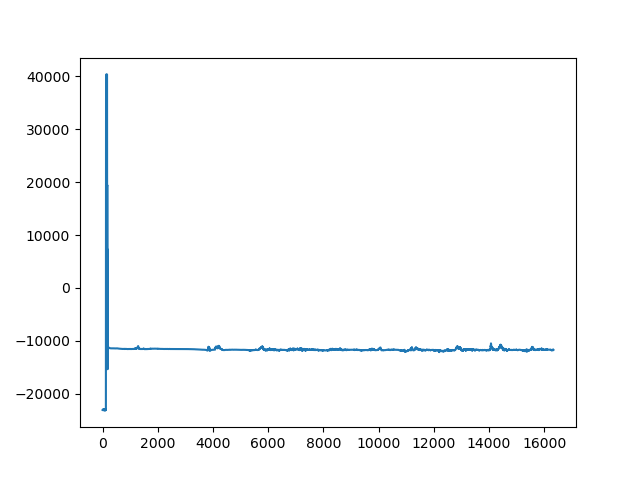

In [16]:
geos2_data['Bx'].plot()

What do you think the duration of the warm-up period? Is it the same for all three magnetometers?

### 2. Downloading GIMA and USGS Magnetometer Data
Next step to investigate our EZIE magnetometer measurements is to understand their accuracy. For this, we need to download magnetometer measurements for scientific grade instruments. There are two magnetometer stations one from Geophysical Institute Magnetometer Array (GIMA) at Poker Flat, AK and another from U.S. Geological Survey at College, AK. The widely used code names for these magnetometers are 'PKR'/'POKR' and 'CMO' respectively. We will use the SPEDAS package to download the data for these two sites.

In [17]:
# Libraries for downloading professional grade magnetometer measurements
import pyspedas 

Then we will need to set a time range, using start and stop times. These times are passed as strings to the pyspedas.themis.gmag library. You can instead use any start_time and end_time in datetime.datetime format. Here, I am using the first and last time entries in the geos1_data to match the data with our measurements.

In [18]:
#set start and end time for data analysis
start_time = pd.to_datetime(geos1_data.timeString.iloc[0])
end_time = pd.to_datetime(geos1_data.timeString.iloc[-1])
trange = [start_time.strftime('%Y-%m-%d/%H:%M:%S'), end_time.strftime('%Y-%m-%d/%H:%M:%S')]

Let's first download the data from Poker Flat station. We can pass sites=['pokr', 'cmo'] and download data simultaneously but for demonstraton purposes, I will download and assign data separately.

In [19]:
poker_data = pyspedas.themis.gmag(trange=trange, sites=['pokr'], 
                                level='l2', time_clip=True,notplot=True)


19-Feb-25 00:07:53: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/pokr/2025/
19-Feb-25 00:07:53: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250205_v01.cdf
19-Feb-25 00:07:54: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250206_v01.cdf
19-Feb-25 00:07:54: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250207_v01.cdf
19-Feb-25 00:07:54: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250208_v01.cdf
19-Feb-25 00:07:55: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250209_v01.cdf
19-Feb-25 00:07:55: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250210_v01.cdf
19-Feb-25 00:07:55: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250211_v01.cdf
19-Feb-25 00:07:56: File is current: themis_data/thg/l2/mag/pokr/2025/thg_l2_mag_pokr_20250212_v01.cdf
19-Feb-25 00:07:56: File is current: themis_data/thg/l2/mag/pokr

Let's check what the data looks like.

In [20]:
poker_data

{'thg_mag_pokr': {'x': array([1.7387136e+09, 1.7387136e+09, 1.7387136e+09, ..., 1.7397504e+09,
         1.7397504e+09, 1.7397504e+09]),
  'y': array([[11417.303 , -1671.9031, 53899.59  ],
         [11417.284 , -1671.9313, 53899.62  ],
         [11417.281 , -1671.9469, 53899.625 ],
         ...,
         [11046.8125, -1758.3313, 54017.695 ],
         [11046.685 , -1758.35  , 54017.723 ],
         [11046.597 , -1758.3188, 54017.758 ]], dtype=float32),
  'v': array([1, 2, 3], dtype=int32)}}

The data is read into a dictionary. This is different than the Pandas Dataframe. Here the 'x' is unixtime, 'y' is the magnetometer measurements, with each column representing Bx, By, Bz. Now, we will do the same for College site.

In [21]:
college_data = pyspedas.themis.gmag(trange=trange, sites=['cmo'], 
                                level='l2', time_clip=True,notplot=True)

19-Feb-25 00:07:57: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/cmo/2025/
19-Feb-25 00:07:58: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250205_v01.cdf
19-Feb-25 00:07:58: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250206_v01.cdf
19-Feb-25 00:07:58: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250207_v01.cdf
19-Feb-25 00:07:59: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250208_v01.cdf
19-Feb-25 00:07:59: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250209_v01.cdf
19-Feb-25 00:07:59: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250210_v01.cdf
19-Feb-25 00:08:00: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250211_v01.cdf
19-Feb-25 00:08:00: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_cmo_20250212_v01.cdf
19-Feb-25 00:08:00: File is current: themis_data/thg/l2/mag/cmo/2025/thg_l2_mag_c

Finally, we need to convert the UnixTime to UT time.

In [22]:
poker_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in poker_data['thg_mag_pokr']['x']]
college_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in college_data['thg_mag_cmo']['x']]

### 3. Comparing EZIE measurements with the science grade magnetometers
Now that we have our own EZIE magnetometer measurements and science grade measurements, let's plot and compare the results. Below I will provide lines of code required to plot different components of the data set. Feel free to modify them as you see fit for your purposes. 

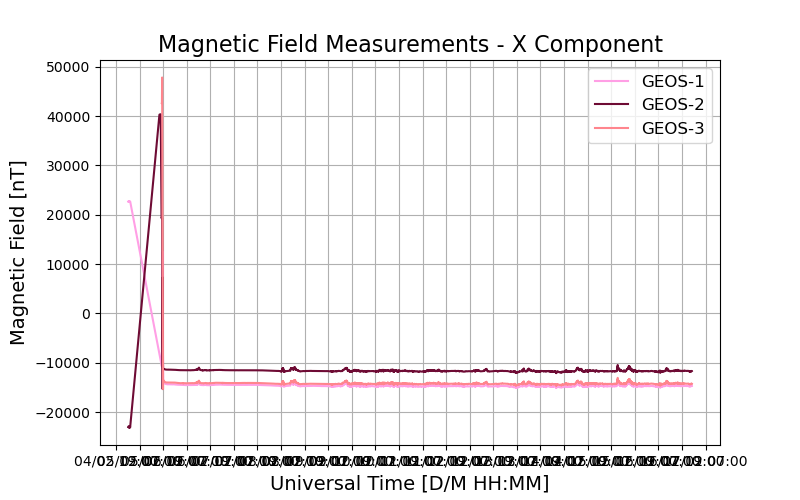

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(geos1_data['timeString'], geos1_data['Bx'], color='#FF9FE5', label='GEOS-1')
ax.plot(geos2_data['timeString'], geos2_data['Bx'], color='#6E0B34', label='GEOS-2')
ax.plot(geos3_data['timeString'], geos3_data['Bx'], color='#FF858D', label='GEOS-3')

ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Magnetic Field Measurements - X Component', fontsize=16)

# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

ax.legend(loc=1, fontsize=12)
ax.grid()


What are some of the things we can notice right away? Do all three magnetometers have the same warm up period? Do they all have the same values?

In [24]:
geos1_data.Bx.head(10), geos2_data.Bx.head(10), geos3_data.Bx.head(10)

(0    22637.766335
 1    22616.179164
 2    22622.959498
 3    22627.545137
 4    22631.676136
 5    22629.368599
 6    22634.641102
 7    22633.986945
 8    22635.962498
 9    22637.465423
 Name: Bx, dtype: float64,
 0   -23049.482749
 1   -23035.648970
 2   -22989.117169
 3   -22988.427033
 4   -22981.071041
 5   -22981.713750
 6   -22978.235272
 7   -22975.760924
 8   -22984.248608
 9   -22984.883140
 Name: Bx, dtype: float64,
 0    42624.520129
 1    42618.645802
 2    42616.379149
 3    42630.930865
 4    43977.044707
 5    47688.294800
 6    47813.349936
 7    47814.566668
 8    47819.368178
 9    47823.842610
 Name: Bx, dtype: float64)

We can see what we regard as "contaminated period" has different durations for each magnetometer kit. We can either remove the first few minutes from all measurements or remove values based on variability of this duration.

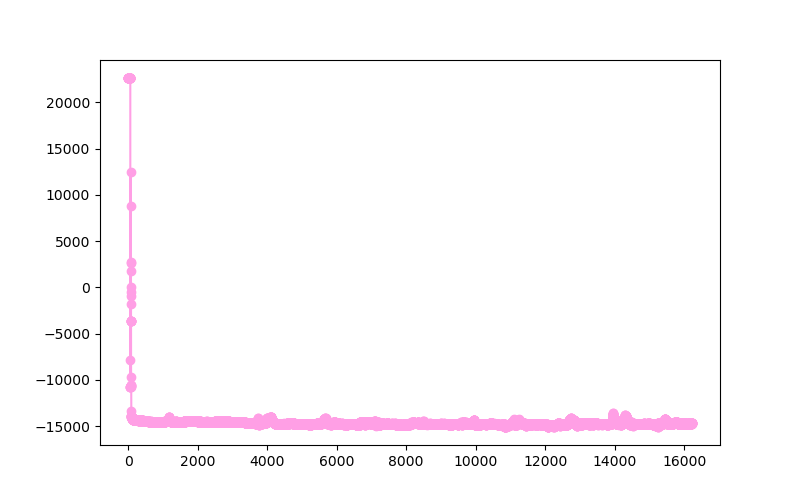

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(geos1_data['Bx'], color='#FF9FE5', marker='o', label='GEOS-1')

In [26]:
geos1_data.drop(geos1_data.index[:90], inplace=True)
geos2_data.drop(geos2_data.index[:90], inplace=True)
geos3_data.drop(geos3_data.index[:90], inplace=True)

Now that we have analyzed the warm-up period and removed these points, let's go ahead and remove the baseline, which is the meadian of each time series. Let's see how much they differ as well.

In [27]:
print(geos1_data['Bx'].median(), geos2_data['Bx'].median(), geos3_data['Bx'].median())

-14724.810528 -11675.8495275 -14266.704592


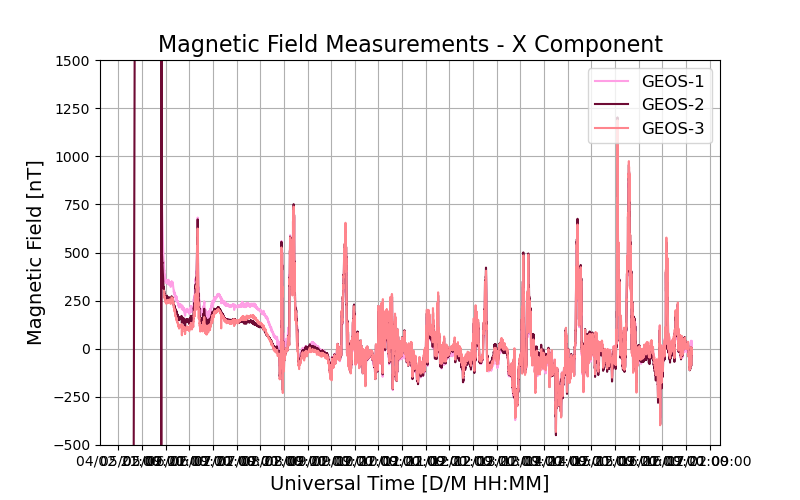

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.plot(geos1_data['timeString'], geos1_data['Bx']-geos1_data['Bx'].median(), color='#FF9FE5', label='GEOS-1')
ax.plot(geos2_data['timeString'], geos2_data['Bx']-geos2_data['Bx'].median(), color='#6E0B34', label='GEOS-2')
ax.plot(geos3_data['timeString'], geos3_data['Bx']-geos3_data['Bx'].median(), color='#FF858D', label='GEOS-3')

ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Magnetic Field Measurements - X Component', fontsize=16)

ax.set_ylim([-500,1500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

ax.legend(loc=1, fontsize=12)
ax.grid()

We have removed the warm-up period but we still have some issues. This is often because for very large values, linear plots tend to trick us. How would the data look like if it was in a logarithmic plot?

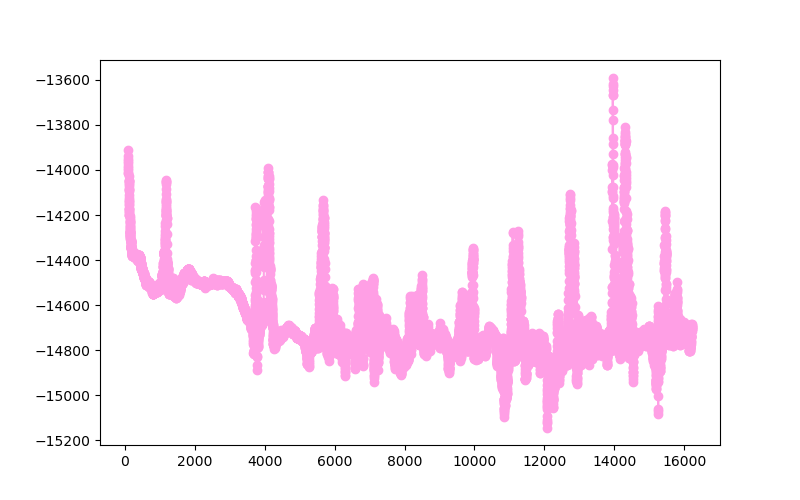

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(geos1_data['Bx'], color='#FF9FE5', marker='o', label='GEOS-1')

Text(0, 0.5, 'Temperature [C]')

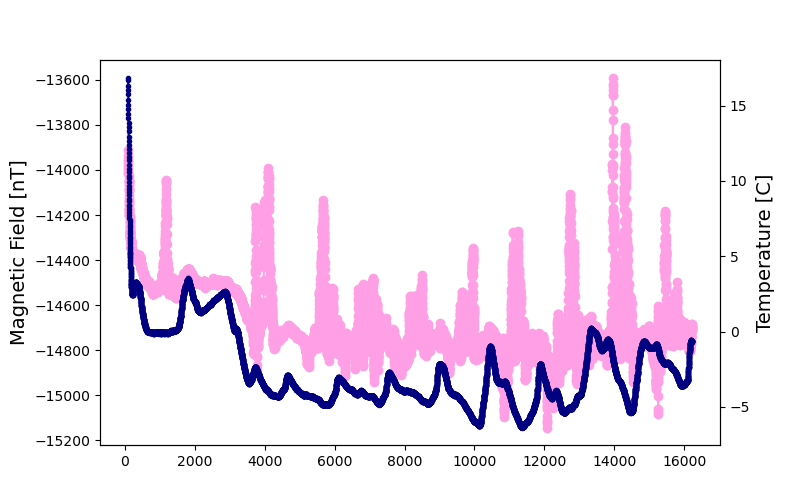

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(geos1_data['Bx'], color='#FF9FE5', marker='o', label='GEOS-1')
ax2 = ax.twinx()
ax2.plot(geos1_data['ctemp'], color='navy', marker='.', label='GEOS-1')
ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax2.set_ylabel('Temperature [C]', fontsize=14)

Temperature correction is beyond the scope of this laboratory exercise. Nominally, you would want to correct for temperature variations by a polynomial fit. Lucky for us, in Alaska, cold winter temperatures act as a first order function. For the sake of the exercise, we will remove the points where temperature drops sharply. 

In [31]:
geos1_data.drop(geos1_data.index[:200], inplace=True)
geos2_data.drop(geos2_data.index[:200], inplace=True)
geos3_data.drop(geos3_data.index[:200], inplace=True)

After we removed these data points, let's go ahead and reset the index.

In [32]:
geos1_data.reset_index(drop=True, inplace=True)
geos2_data.reset_index(drop=True, inplace=True)
geos2_data.reset_index(drop=True, inplace=True)

Now let's add the Poker Flat and College site data to this plot. 

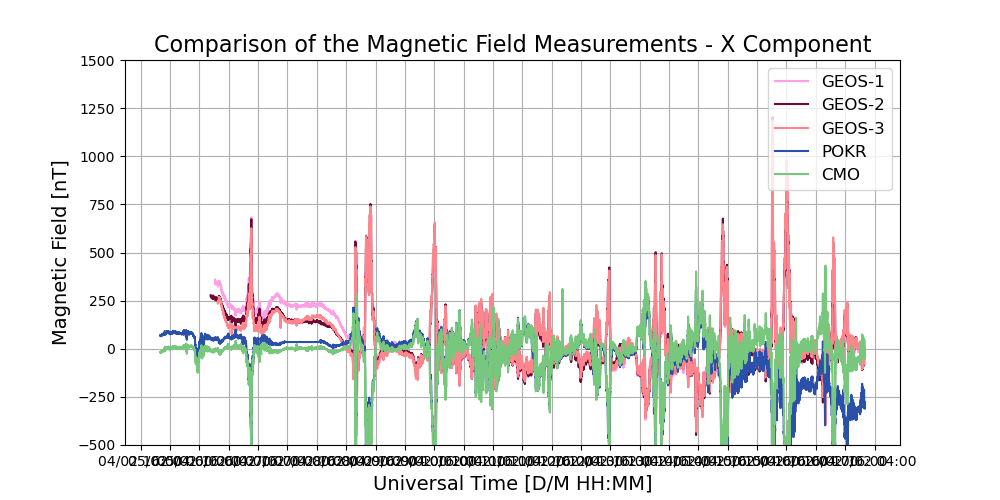

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(geos1_data['timeString'], geos1_data['Bx']-geos1_data['Bx'].median(), color='#FF9FE5', label='GEOS-1')
ax.plot(geos2_data['timeString'], geos2_data['Bx']-geos2_data['Bx'].median(), color='#6E0B34', label='GEOS-2')
ax.plot(geos3_data['timeString'], geos3_data['Bx']-geos3_data['Bx'].median(), color='#FF858D', label='GEOS-3')

ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,0]-np.median(poker_data['thg_mag_pokr']['y'][:,0]), color='#2B50AA', label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,0]-np.median(college_data['thg_mag_cmo']['y'][:,0]), color='#77C77C', label='CMO')

ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - X Component', fontsize=16)

ax.set_ylim([-500,1500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

ax.legend(loc=1, fontsize=12)
ax.grid()

Before we start analyzing the comparison in more depth there are a few more considerations we need to take into account. The first one is the overlapping of lines. We can introduce the alpha, transparency parameter, to show overlapping lines  better. 

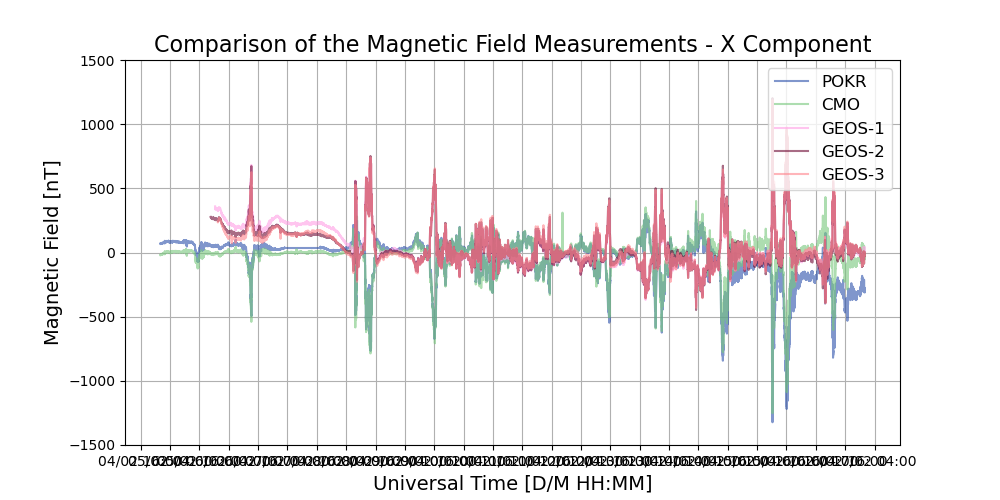

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,0]-np.median(poker_data['thg_mag_pokr']['y'][:,0]), color='#2B50AA', alpha=0.6, label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,0]-np.median(college_data['thg_mag_cmo']['y'][:,0]), color='#77C77C', alpha=0.6, label='CMO')

ax.plot(geos1_data['timeString'], geos1_data['Bx']-geos1_data['Bx'].median(), color='#FF9FE5', alpha=0.6, label='GEOS-1')
ax.plot(geos2_data['timeString'], geos2_data['Bx']-geos2_data['Bx'].median(), color='#6E0B34', alpha=0.6, label='GEOS-2')
ax.plot(geos3_data['timeString'], geos3_data['Bx']-geos3_data['Bx'].median(), color='#FF858D', alpha=0.6, label='GEOS-3')


ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - X Component', fontsize=16)

ax.set_ylim([-1500,1500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))

ax.legend(loc=1, fontsize=12)
ax.grid()

Data seems very odd, almost like we put the sensor in the exact opposite direction. How do we fix that?

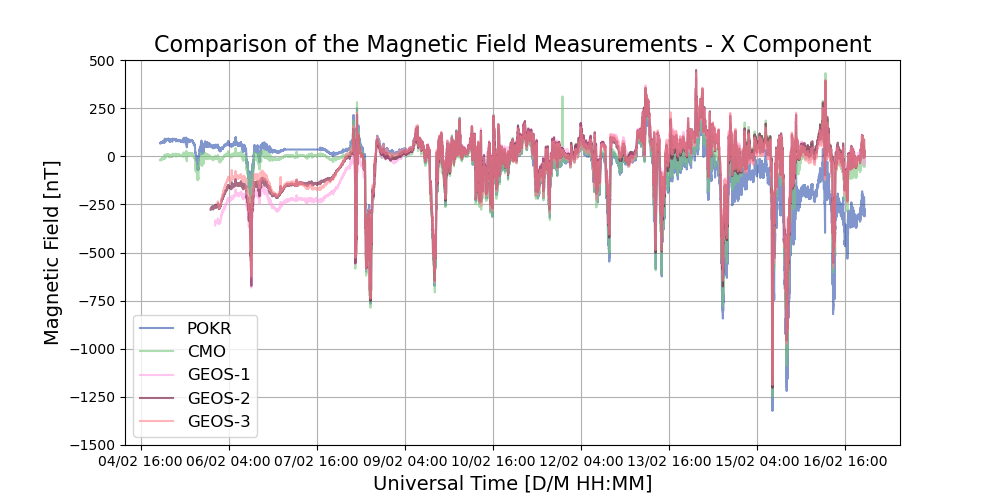

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,0]-np.median(poker_data['thg_mag_pokr']['y'][:,0]), color='#2B50AA', alpha=0.6, label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,0]-np.median(college_data['thg_mag_cmo']['y'][:,0]), color='#77C77C', alpha=0.6, label='CMO')

ax.plot(geos1_data['timeString'], -1*(geos1_data['Bx']-geos1_data['Bx'].median()), color='#FF9FE5', alpha=0.6, label='GEOS-1')
ax.plot(geos2_data['timeString'], -1*(geos2_data['Bx']-geos2_data['Bx'].median()), color='#6E0B34', alpha=0.6, label='GEOS-2')
ax.plot(geos3_data['timeString'], -1*(geos3_data['Bx']-geos3_data['Bx'].median()), color='#FF858D', alpha=0.6, label='GEOS-3')

ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - X Component', fontsize=16)

ax.set_ylim([-1500,500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))

ax.legend(loc=3, fontsize=12)
ax.grid()

fig.savefig('./magnetometer_data_comparison_bx_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

Before we move onto other components, let's try to answer some of these questions.
1. How many substorm like signatures can we count?
2. How long is the duration of a typical substorm?
3. Is there a time of day we see these signatures more often?
4. What is the largest magnetic field perturbation we see?
5. What is the most geomagnetically active day?

What are some other things you notice?

Now let's check out how other components look like.

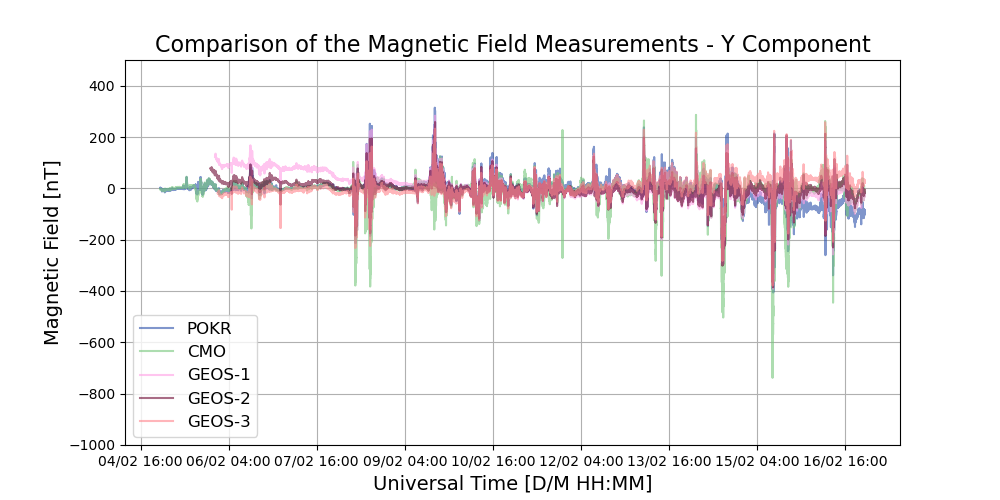

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,1]-np.median(poker_data['thg_mag_pokr']['y'][:,1]), color='#2B50AA', alpha=0.6, label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,1]-np.median(college_data['thg_mag_cmo']['y'][:,1]), color='#77C77C', alpha=0.6, label='CMO')

ax.plot(geos1_data['timeString'], geos1_data['By']-geos1_data['By'].median(), color='#FF9FE5', alpha=0.6, label='GEOS-1')
ax.plot(geos2_data['timeString'], geos2_data['By']-geos2_data['By'].median(), color='#6E0B34', alpha=0.6, label='GEOS-2')
ax.plot(geos3_data['timeString'], geos3_data['By']-geos3_data['By'].median(), color='#FF858D', alpha=0.6, label='GEOS-3')

ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - Y Component', fontsize=16)

ax.set_ylim([-1000,500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))

ax.legend(loc=3, fontsize=12)
ax.grid()

fig.savefig('./magnetometer_data_comparison_by_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

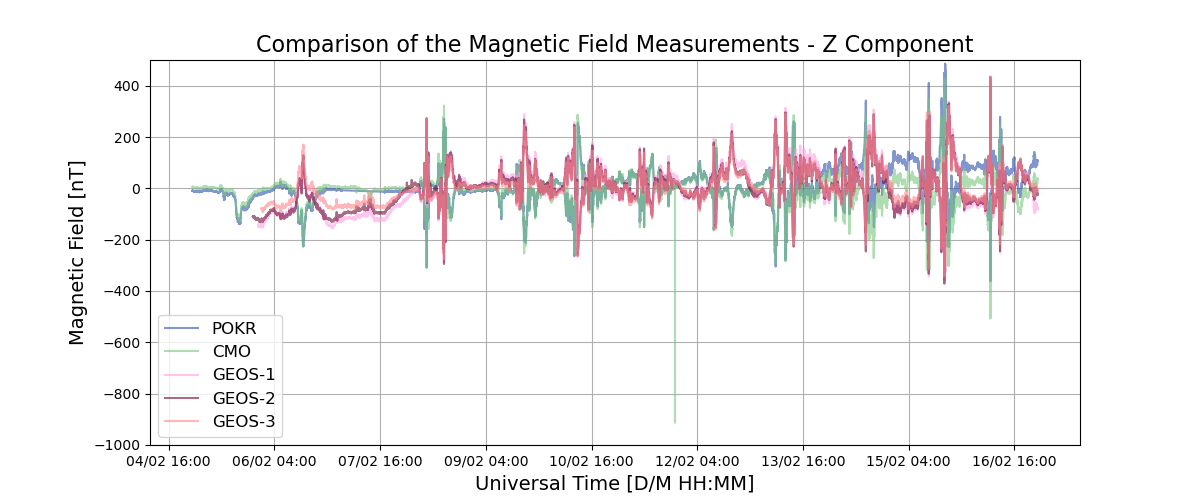

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,2]-np.median(poker_data['thg_mag_pokr']['y'][:,2]), color='#2B50AA', alpha=0.6, label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,2]-np.median(college_data['thg_mag_cmo']['y'][:,2]), color='#77C77C', alpha=0.6, label='CMO')

ax.plot(geos1_data['timeString'], (geos1_data['Bz']-geos1_data['Bz'].median()), color='#FF9FE5', alpha=0.6, label='GEOS-1')
ax.plot(geos2_data['timeString'], (geos2_data['Bz']-geos2_data['Bz'].median()), color='#6E0B34', alpha=0.6, label='GEOS-2')
ax.plot(geos3_data['timeString'], (geos3_data['Bz']-geos3_data['Bz'].median()), color='#FF858D', alpha=0.6, label='GEOS-3')


ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - Z Component', fontsize=16)

ax.set_ylim([-1000,500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))

ax.legend(loc=3, fontsize=12)
ax.grid()

#fig.savefig('./magnetometer_data_comparison_bz_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

The z-component also seems to be upside-down. This is not a simple orientation error. Checking with the JHU/APL, it is actually an erroneous sensor. 

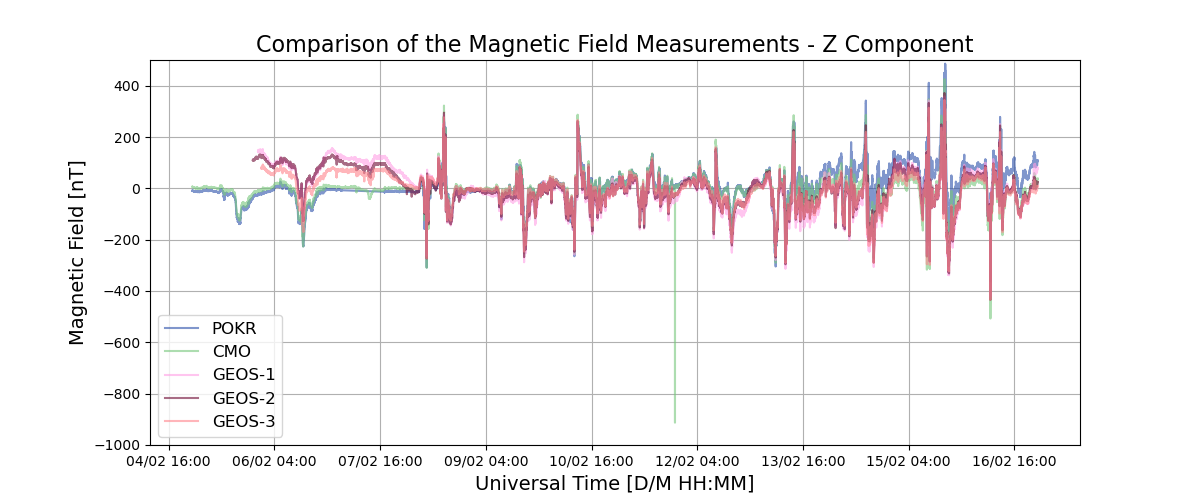

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(poker_time_array, poker_data['thg_mag_pokr']['y'][:,2]-np.median(poker_data['thg_mag_pokr']['y'][:,2]), color='#2B50AA', alpha=0.6, label='POKR')
ax.plot(college_time_array, college_data['thg_mag_cmo']['y'][:,2]-np.median(college_data['thg_mag_cmo']['y'][:,2]), color='#77C77C', alpha=0.6, label='CMO')

ax.plot(geos1_data['timeString'], -1*(geos1_data['Bz']-geos1_data['Bz'].median()), color='#FF9FE5', alpha=0.6, label='GEOS-1')
ax.plot(geos2_data['timeString'], -1*(geos2_data['Bz']-geos2_data['Bz'].median()), color='#6E0B34', alpha=0.6, label='GEOS-2')
ax.plot(geos3_data['timeString'], -1*(geos3_data['Bz']-geos3_data['Bz'].median()), color='#FF858D', alpha=0.6, label='GEOS-3')


ax.set_ylabel('Magnetic Field [nT]', fontsize=14)
ax.set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
ax.set_title('Comparison of the Magnetic Field Measurements - Z Component', fontsize=16)

ax.set_ylim([-1000,500])
# Set the date format on the x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Optionally, you can set the locator for the ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))

ax.legend(loc=3, fontsize=12)
ax.grid()

fig.savefig('./magnetometer_data_comparison_bz_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

### 4.Investigating the spatial extent of the geomagnetic perturbations

####    Comparison along a similar longitude
Let's start with determining the spatial extent by comparing our magnetometer results with USGS magnetometers in Alaska. This will help us determine the latitudinal extent of the geomagnetic disturbances. Remember this is about how far the center of the ionospheric overhead current is. We will use the 'BRW' and 'SHU' sites.

In [39]:
barrow_data = pyspedas.themis.gmag(trange=trange, sites=['brw'], 
                                level='l2', time_clip=True,notplot=True)


barrow_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in barrow_data['thg_mag_brw']['x']]

19-Feb-25 00:09:04: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/brw/2025/
19-Feb-25 00:09:04: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250205_v01.cdf
19-Feb-25 00:09:04: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250206_v01.cdf
19-Feb-25 00:09:05: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250207_v01.cdf
19-Feb-25 00:09:05: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250208_v01.cdf
19-Feb-25 00:09:05: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250209_v01.cdf
19-Feb-25 00:09:06: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250210_v01.cdf
19-Feb-25 00:09:06: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250211_v01.cdf
19-Feb-25 00:09:07: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_brw_20250212_v01.cdf
19-Feb-25 00:09:07: File is current: themis_data/thg/l2/mag/brw/2025/thg_l2_mag_b

In [40]:
shumagin_data = pyspedas.themis.gmag(trange=trange, sites=['shu'], 
                                level='l2', time_clip=True,notplot=True)

shumagin_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in shumagin_data['thg_mag_shu']['x']]

19-Feb-25 00:09:10: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/shu/2025/
19-Feb-25 00:09:11: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250205_v01.cdf
19-Feb-25 00:09:13: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250206_v01.cdf
19-Feb-25 00:09:13: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250207_v01.cdf
19-Feb-25 00:09:13: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250208_v01.cdf
19-Feb-25 00:09:14: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250209_v01.cdf
19-Feb-25 00:09:14: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250210_v01.cdf
19-Feb-25 00:09:14: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250211_v01.cdf
19-Feb-25 00:09:15: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_shu_20250212_v01.cdf
19-Feb-25 00:09:15: File is current: themis_data/thg/l2/mag/shu/2025/thg_l2_mag_s

Now let's plot the data.

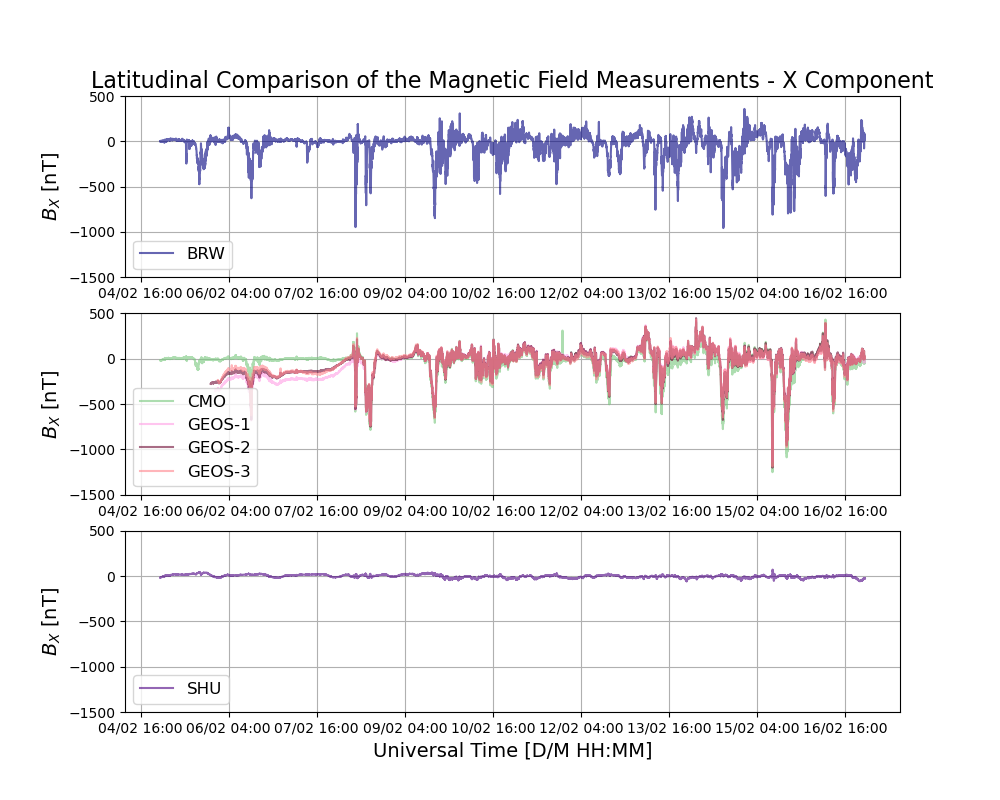

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(10,8))

axes[0].plot(barrow_time_array, barrow_data['thg_mag_brw']['y'][:,0]-np.median(barrow_data['thg_mag_brw']['y'][:,0]), color='navy', alpha=0.6, label='BRW')


axes[1].plot(college_time_array, college_data['thg_mag_cmo']['y'][:,0]-np.median(college_data['thg_mag_cmo']['y'][:,0]), color='#77C77C', alpha=0.6, label='CMO')

axes[1].plot(geos1_data['timeString'], -1*(geos1_data['Bx']-geos1_data['Bx'].median()), color='#FF9FE5', alpha=0.6, label='GEOS-1')
axes[1].plot(geos2_data['timeString'], -1*(geos2_data['Bx']-geos2_data['Bx'].median()), color='#6E0B34', alpha=0.6, label='GEOS-2')
axes[1].plot(geos3_data['timeString'], -1*(geos3_data['Bx']-geos3_data['Bx'].median()), color='#FF858D', alpha=0.6, label='GEOS-3')

axes[2].plot(shumagin_time_array, shumagin_data['thg_mag_shu']['y'][:,0]-np.median(shumagin_data['thg_mag_shu']['y'][:,0]), color='indigo', alpha=0.6, label='SHU')

for ax in axes:
    ax.set_ylabel('$B_{X}$ [nT]', fontsize=14)
    
    ax.set_ylim([-1500,500])
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))
    ax.legend(loc=3, fontsize=12)
    ax.grid()

axes[2].set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
axes[0].set_title('Latitudinal Comparison of the Magnetic Field Measurements - X Component', fontsize=16)


fig.savefig('./latitudinal_magnetometer_data_comparison_bx_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

What can we tell about the ionospheric current system? Can we tell where is the center of the overhead current?

#### Comparison along similar latitudes

Now let's look at the longitudinal extent of these perturbations by comparing the measurements with other magnetometer across the globe which are deployed in similar latitudes to Fairbanks, AK. We are going to use Leirvogur ('LRV'; Iceland), Roervik ('RVK'; Norway) and Baker Lake ('BLC'; Canada).

In [42]:
leirvogur_data = pyspedas.themis.gmag(trange=trange, sites=['lrv'], 
                                level='l2', time_clip=True,notplot=True)

leirvogur_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in leirvogur_data['thg_mag_lrv']['x']]

19-Feb-25 00:09:29: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/lrv/2025/
19-Feb-25 00:09:30: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250205_v01.cdf
19-Feb-25 00:09:30: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250206_v01.cdf
19-Feb-25 00:09:30: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250207_v01.cdf
19-Feb-25 00:09:31: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250208_v01.cdf
19-Feb-25 00:09:31: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250209_v01.cdf
19-Feb-25 00:09:31: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250210_v01.cdf
19-Feb-25 00:09:32: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250211_v01.cdf
19-Feb-25 00:09:32: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_lrv_20250212_v01.cdf
19-Feb-25 00:09:32: File is current: themis_data/thg/l2/mag/lrv/2025/thg_l2_mag_l

In [43]:
roervik_data = pyspedas.themis.gmag(trange=trange, sites=['rvk'], 
                                level='l2', time_clip=True,notplot=True)

roervik_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in roervik_data['thg_mag_rvk']['x']]

19-Feb-25 00:09:34: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/greenland_gmag/l2/rvk/2025/
19-Feb-25 00:09:35: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250205_v01.cdf
19-Feb-25 00:09:36: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250206_v01.cdf
19-Feb-25 00:09:37: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250207_v01.cdf
19-Feb-25 00:09:37: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250208_v01.cdf
19-Feb-25 00:09:38: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250209_v01.cdf
19-Feb-25 00:09:38: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250210_v01.cdf
19-Feb-25 00:09:39: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk_20250211_v01.cdf
19-Feb-25 00:09:39: File is current: themis_data/thg/greenland_gmag/l2/rvk/2025/thg_l2_mag_rvk

In [44]:
baker_data = pyspedas.themis.gmag(trange=trange, sites=['blc'], 
                                level='l2', time_clip=True,notplot=True)

baker_time_array = [dt.datetime(1970, 1, 1) + dt.timedelta(seconds=seconds) for seconds in baker_data['thg_mag_blc']['x']]

19-Feb-25 00:09:42: Downloading remote index: https://themis.ssl.berkeley.edu/data/themis/thg/l2/mag/blc/2025/
19-Feb-25 00:09:43: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250205_v01.cdf
19-Feb-25 00:09:43: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250206_v01.cdf
19-Feb-25 00:09:43: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250207_v01.cdf
19-Feb-25 00:09:44: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250208_v01.cdf
19-Feb-25 00:09:44: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250209_v01.cdf
19-Feb-25 00:09:45: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250210_v01.cdf
19-Feb-25 00:09:45: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250211_v01.cdf
19-Feb-25 00:09:46: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_blc_20250212_v01.cdf
19-Feb-25 00:09:46: File is current: themis_data/thg/l2/mag/blc/2025/thg_l2_mag_b

Now let's plot the data.

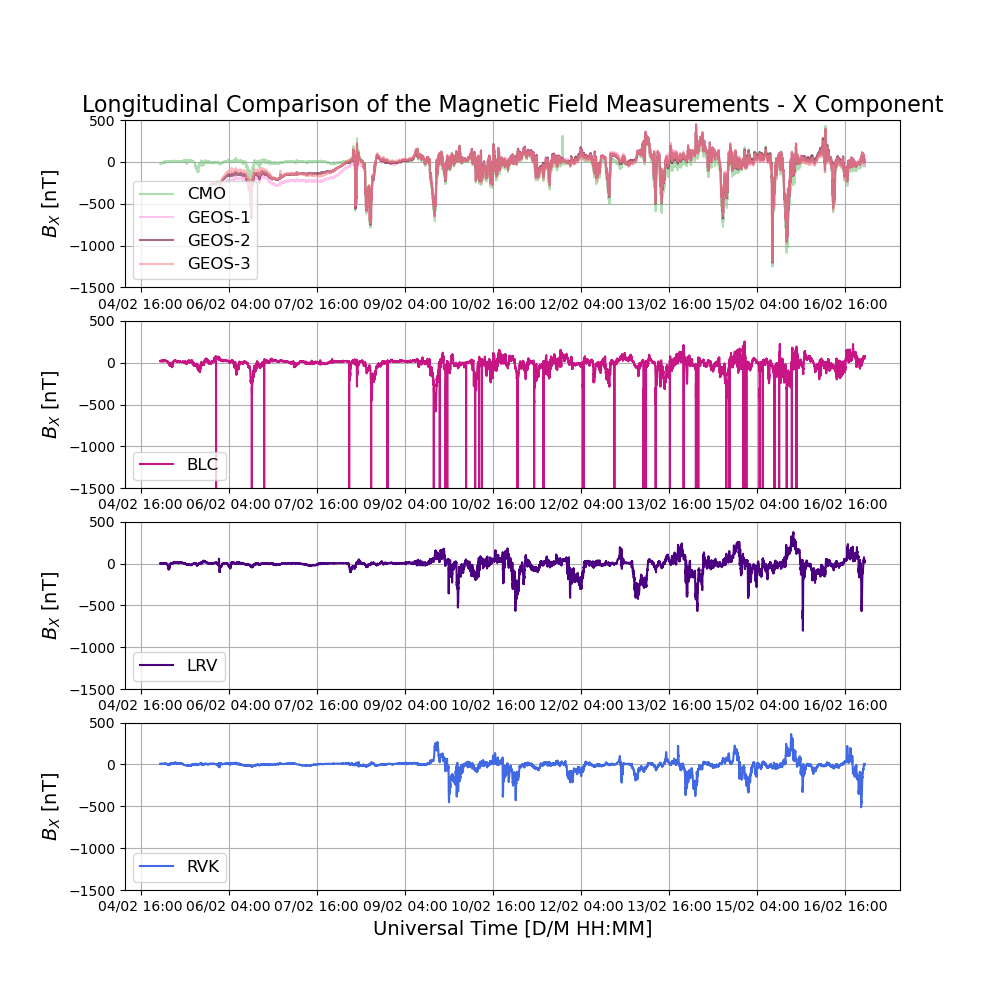

In [45]:
fig, axes = plt.subplots(4, 1, figsize=(10,10))



axes[0].plot(college_time_array, college_data['thg_mag_cmo']['y'][:,0]-np.median(college_data['thg_mag_cmo']['y'][:,0]), color='#77C77C', alpha=0.6, label='CMO')

axes[0].plot(geos1_data['timeString'], -1*(geos1_data['Bx']-geos1_data['Bx'].median()), color='#FF9FE5', alpha=0.6, label='GEOS-1')
axes[0].plot(geos2_data['timeString'], -1*(geos2_data['Bx']-geos2_data['Bx'].median()), color='#6E0B34', alpha=0.6, label='GEOS-2')
axes[0].plot(geos3_data['timeString'], -1*(geos3_data['Bx']-geos3_data['Bx'].median()), color='#FF858D', alpha=0.6, label='GEOS-3')

axes[1].plot(baker_time_array, baker_data['thg_mag_blc']['y'][:,0]-np.median(baker_data['thg_mag_blc']['y'][:,0]), color='mediumvioletred', label='BLC')
axes[2].plot(leirvogur_time_array, leirvogur_data['thg_mag_lrv']['y'][:,0]-np.median(leirvogur_data['thg_mag_lrv']['y'][:,0]), color='indigo', label='LRV')
axes[3].plot(roervik_time_array, roervik_data['thg_mag_rvk']['y'][:,0]-np.median(roervik_data['thg_mag_rvk']['y'][:,0]), color='royalblue', label='RVK')

for ax in axes:
    ax.set_ylabel('$B_{X}$ [nT]', fontsize=14)
    
    ax.set_ylim([-1500,500])
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=36))
    ax.legend(loc=3, fontsize=12)
    ax.grid()

axes[3].set_xlabel('Universal Time [D/M HH:MM]', fontsize=14)
axes[0].set_title('Longitudinal Comparison of the Magnetic Field Measurements - X Component', fontsize=16)


fig.savefig('./longitudinal_magnetometer_data_comparison_bx_{0:%Y_%m_%d_%H}.png'.format(geos1_data['timeString'].iloc[0]), bbox_inches='tight', dpi=200)

Let's try to answer the following questions.
1. Which intervals are recorded as geomagnetically disturbed in all four magnetometer stations?
2. Which intervals are localized?
3. Do stations close to each other record the same magnetic signatures?